Exploratory data analysis is *exploratory* by nature, often used to get a sense of the content and structure of a dataset before diving into specific research questions.  For this homework, you have one task: tell us something interesting about a dataset using topic modeling. You are free to use any dataset (even those from Kaggle this time), but see sample datasets below:

* [CMU Book Summary Dataset](https://www.cs.cmu.edu/~dbamman/booksummaries.html)
    * Metadata: Title, author, publication date, genre

* [CMU Movie Summary Dataset](http://www.cs.cmu.edu/~ark/personas/)
    * Metadata: Movie box office revenue, genre, release date, runtime, and language

* [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
    * Metadata: positive/negative sentiment
    
* [Congressional Speech Data](https://www.cs.cornell.edu/home/llee/data/convote.html)
    * Metadata: political party
    
* [100K ArXiv abstracts](https://drive.google.com/file/d/1ThK1D9AstYI6s2Z7m9SmvLqLZPneMp12/view?usp=sharing)
    * Metadata: ArXiv subject (e.g., math, physics, cs)

For any dataset, you'll have to understand the format in order to read in the textual part (and any metadata of interest); and then tokenize the text before passing it on to topic modeling.

Refer to `4.eda/TopicModel.ipynb` for example code on how to work with topic models in gensim, and remember that we've considered several concepts already for characterizing differences across groups; feel free to draw on those as you see appropriate for this exploration.

A **check** submission will run topic modeling on the text of your chosen dataset and discuss the topics that emerge; a **check-plus** submission will relate variation in those topics to aspects of metadata (e.g., discussing interesting topical differences over time or between genre/political party, etc.).  In all cases, be sure to explain why what you have found is interesting.

---

In the following work, I demonstrated applying topic models to the `CMU Book Summary Dataset`. I first did an EDA on the dataset, and decided to focus on books that have been categorized into the `Romance novel` genre. The topic model was implemented on this subset of the data exclusively. 

The meta data I'm interested in is the `publication year`. Specifically, I wanted to know, within the genre of `Romance novel`, what kind of topic is written most about in what period of time, over the past two centuries. 

In [1]:
import nltk
import re
import gensim
from gensim import corpora
import pandas as pd
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

nltk.download('stopwords')
from nltk.corpus import stopwords
random.seed(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mingyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# from TopicModel.ipynb
def read_stopwords(filename):
    stopwords={}
    with open(filename) as file:
        for line in file:
            stopwords[line.rstrip()]=1
    return stopwords

In [3]:
# from TopicModel.ipynb
stop_words = {k:1 for k in stopwords.words('english')}
stop_words.update(read_stopwords("../data/jockers.stopwords"))
stop_words["'s"]=1
stop_words=list(stop_words.keys())

In [4]:
# from TopicModel.ipynb
def filter(word, stopwords):
    
    """ Function to exclude words from a text """
    
    # no stopwords
    if word in stopwords:
        return False
    
    # has to contain at least one letter
    if re.search("[A-Za-z]", word) is not None:
        return True
    
    return False

In [5]:
# read booksummaries.txt in as a dataframe
books = pd.read_table("../data/booksummaries.txt", sep="\t", 
                     names=['wiki_id', 'freebase_id', 'title', 'author', 'publication_date', 'genres', 'summary'])

# expand the date column to year, month, and day
books[["year", "month", "day"]] = books["publication_date"].str.split("-", expand = True)

# convert the string dict which holds the genre to dict 
convert_to_dict = lambda x: list(eval(x).values()) if not pd.isna(x) else x
books['genre_dict'] = books['genres'].apply(convert_to_dict)

# explode the dataframe based on the genre list 
books_eda = books.explode('genre_dict').reset_index(drop=True)

# convert the year column from string to numeric
books_eda['year'] = pd.to_numeric(books_eda['year'], errors='coerce')

In [6]:
# check the most frequent genres
books_eda['genre_dict'].value_counts()[:20]

genre_dict
Fiction                   4747
Speculative fiction       4314
Science Fiction           2870
Novel                     2463
Fantasy                   2413
Children's literature     2122
Mystery                   1396
Young adult literature     825
Suspense                   765
Crime Fiction              753
Historical novel           654
Thriller                   568
Horror                     511
Romance novel              435
Historical fiction         388
Detective fiction          341
Adventure novel            330
Non-fiction                230
Alternate history          226
Spy fiction                190
Name: count, dtype: int64

In [7]:
def read_docs(data, stopwords, genres):
    
    # subset dataframe based on selected genres
    subset = data.loc[data["genre_dict"].isin(genres)].reset_index(drop=True)
    
    # tokenization & remove stopwords
    tokens_filtered = []
    for i in subset["summary"].to_list():
        tokens = nltk.word_tokenize(i.lower())
        tokens_filtered.append([x for x in tokens if filter(x, stop_words)])
    
    # output meta data and text
    meta = subset["year"].to_list()
    title = subset["title"].to_list()
    ids = subset.index.to_list()
    assert len(tokens_filtered) == len(meta) == len(title)
    
    print(f"The data is ready for the genre: {genres}")
    return title, meta, tokens_filtered

In [8]:
# get tokenized text and meta data
genres = ["Romance novel"]
title, meta, tokens = read_docs(books_eda, stop_words, genres)

The data is ready for the genre: ['Romance novel']


In [9]:
# create a dict from gensim
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=5, no_above=.5, keep_n=10000)

# convert dict to bag-of-words
corpus = [dictionary.doc2bow(text) for text in tokens]

In [10]:
# create a topic model 
num_topics=6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           passes=10,
                                           alpha='auto', 
                                           random_state=1)

In [11]:
# print topics for selected genre
for i in range(num_topics):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in lda_model.show_topic(i, topn=15)])))

topic 0:	tells n't time day house finds goes says life asks mother find school father away
topic 1:	vampire pack mother vampires life father death werewolf kill world men help friend human novel
topic 2:	novel father story life woman family death mother marriage de husband years finds time affair
topic 3:	sookie time life mr. brother family wife father years takes mrs. old husband returns friend
topic 4:	mother family father life novel house marriage begins wife book death children away relationship eventually
topic 5:	family father time opera york wife de book story years mother daughter friend holland loveday


---

Topic 0 is picking out words that are relevant to everyday life `time`, `day`, `house`, `life`, `school`.

Topic 1, clearly, points to `vampire(s)`, `death`, `werewolf`, `kill`. Note that the first defining term of topic 3 is `sookie`, which is a character name of a vampire novel series. It seems that topic 1 and topic 3 are capturing very similar topics--romance stories in vampire or mysterious settings. 

Topic 2 highlights tokens such as `woman`, `family`, `marriage`, and `husband`, which are expected in classic romance novels. 

Topic 4 is picking out similar key tokens, except more family and kinship terms emerge `mother`, `family`, `father`, `wife`, and `children`.

Lastly, topic 5 includes key tokens that are place names--`york` and`holland`, as well as kinship terms again `father`, `wife`, `mother`, `daughter`. 

It is interesting that all topics either include the token `family` or `life`. 

We can summarize the topic tokens generated above using a short description, shown as below. 

In [12]:
# create a short description for each topic
description = ["everyday life narratives",
               "vampire/mysterious",
               "classic romance story",
               "vampire/mysterious",
               "family and maritial bonds",
               "european romance story"]

# print out the description for each topic
for i in range(num_topics):
    print("topic %s:\t%s" % (i, description[i]))

topic 0:	everyday life narratives
topic 1:	vampire/mysterious
topic 2:	classic romance story
topic 3:	vampire/mysterious
topic 4:	family and maritial bonds
topic 5:	european romance story


In [13]:
topic_model=lda_model 

topic_docs=[]
for i in range(num_topics):
    topic_docs.append({})
    
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][doc_id]=topic_prob

YEAR = []
SCORE = []
for i in range(num_topics):
    #print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=15)]))
    sorted_x = sorted(topic_docs[i].items(), key=operator.itemgetter(1), reverse=True)  
    years = []
    scores = []
    for k, v in sorted_x:
        years.append(meta[k])
        scores.append(v)
    YEAR.append(years)
    SCORE.append(scores)

    # sns.histplot(years, stat='density', binrange=(1800, 2015), bins=15)
    # plt.ylim(0, 0.05)
    # plt.show()

In [14]:
df = pd.DataFrame(np.arange(num_topics), columns=["id"])
df["description"] = description
df["year"] = YEAR
df["score"] = SCORE
df = df.explode(["year", "score"]).reset_index(drop=True)

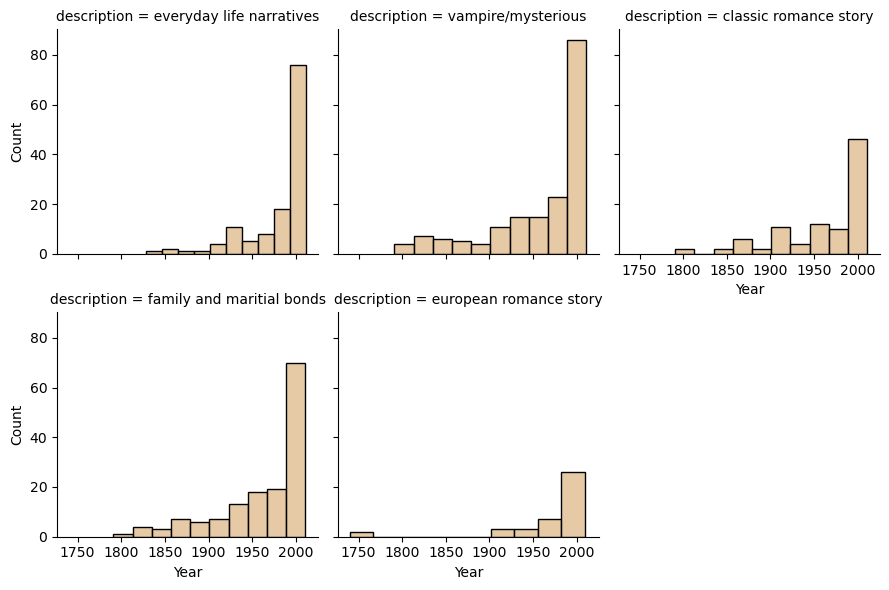

In [15]:
g = sns.FacetGrid(df, col="description", col_wrap=3, despine=True)
g.map(sns.histplot, "year", bins=10, color="burlywood")
g.set_xlabels('Year')
g.set_ylabels('Count');

The above graph is a histogram of `publication year` of books that contain a particular topic. It seems that overall romance novels published after 2000 experience greatest increase. Among them, topics such as `everyday narratives`, `vampire/mysterious`, and `family and maritial bonds` are published more often than other topics--`classic romance story` and `English romance story`. Noticeably, these two topics are among the books that were published earliest in the dataset. 

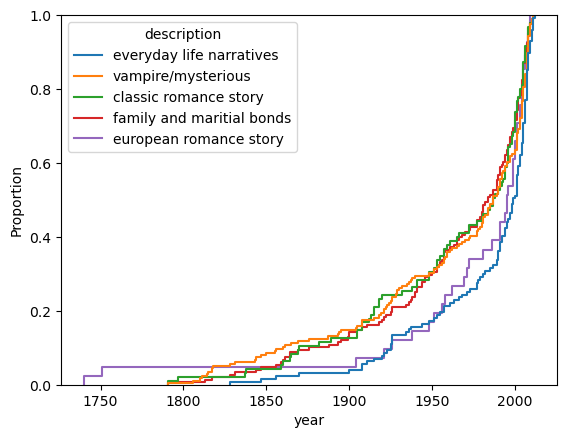

In [16]:
sns.ecdfplot(data=df, x="year", hue="description");